In [1]:
import numpy as np
from MultiStepLSTM import WirelineLog
import matplotlib.pyplot as plt
from scipy import signal
from sys import getsizeof


Using TensorFlow backend.


In [152]:
log = WirelineLog()
log.read("/home/duys/Downloads/anadarko.las")
log_data = log.df
ccl = log_data['CCL'].dropna()

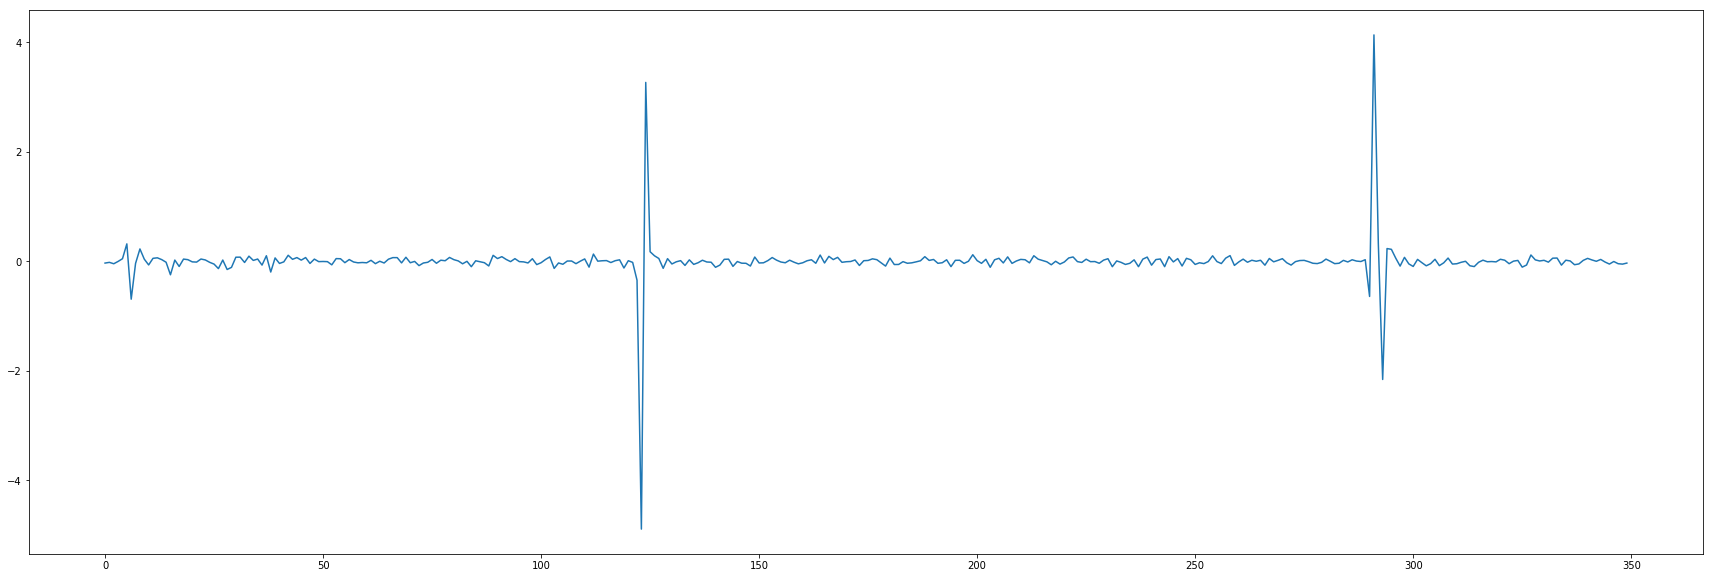

In [157]:
plt.figure(figsize=(30,10))
plt.plot(ccl.values[0:350])

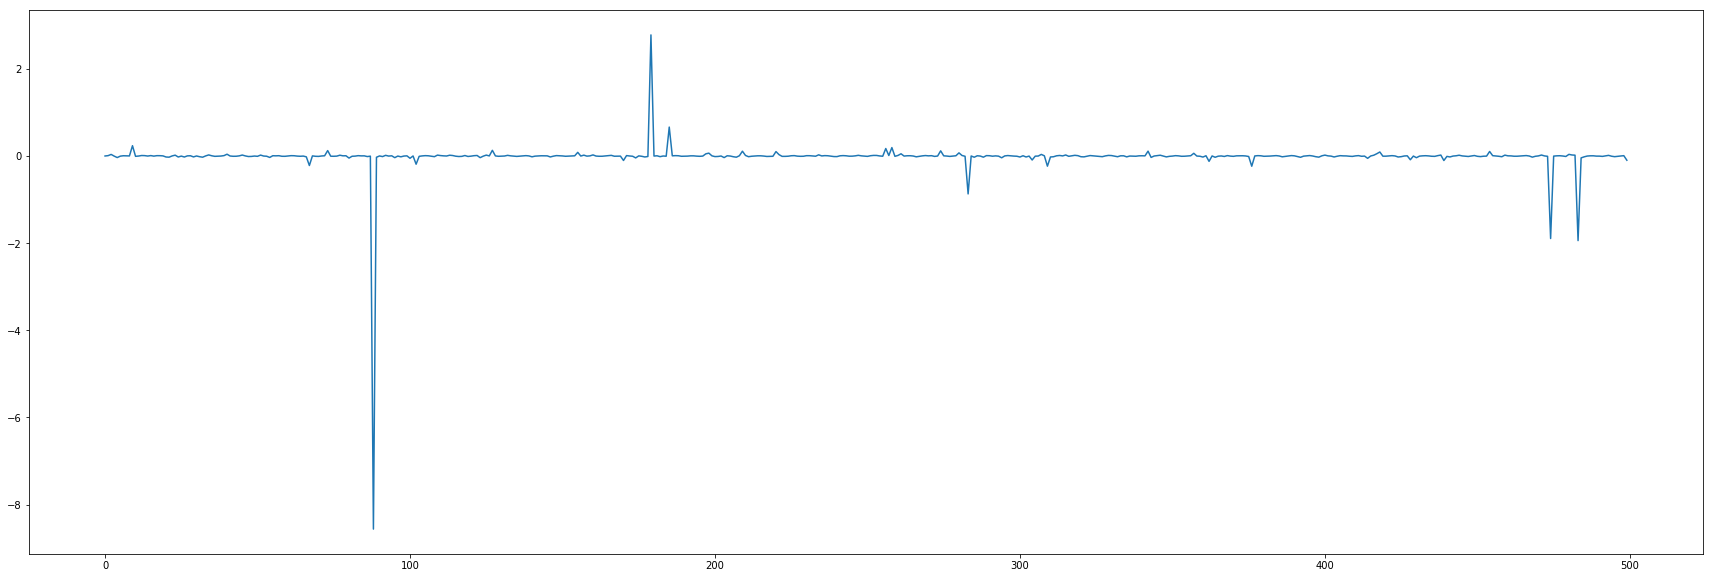

In [169]:
# x = np.linspace(0,100, 100); print(x.shape)
# #y = 0.09 * np.sin(20 * x)

def sin_x(x, a=0.01, b=20, rand_div=1.09):
    return (a * np.sin(b * x)) / (1-(np.random.randn()/rand_div))

y = []
for i in range(500):
    v = sin_x(i, a = 0.01, b=20, rand_div=1.09)
    
    if i % 40 == 0:
        y.append(sin_x(i, a = 0.04, b=20, rand_div=1.6))
    else:
        y.append(v)
        
plt.figure(figsize=(30,10))
plt.plot(y)
#plt.plot(anom, c='r')
y = []

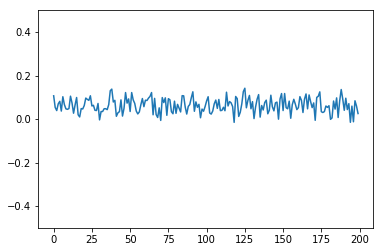

In [111]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale

np.random.seed(123)
t = np.arange(0, 6799, 1)

message_freq = 2
message = np.sin(2*message_freq*t)
carrier_freq = 500


class AmplitudeModem:
    
    @staticmethod
    def modulate(message, fc):
        c = np.cos(6.28*fc*t)

        mod = 0.2*message*c
        return mod
    
modulated = AmplitudeModem.modulate(message, carrier_freq)
modulated = 0.02* np.cos(0.5*t) + np.random.rand(*t.shape)/8
plt.ylim(-.5,.5)
plt.plot(modulated[:200])

(6799,)


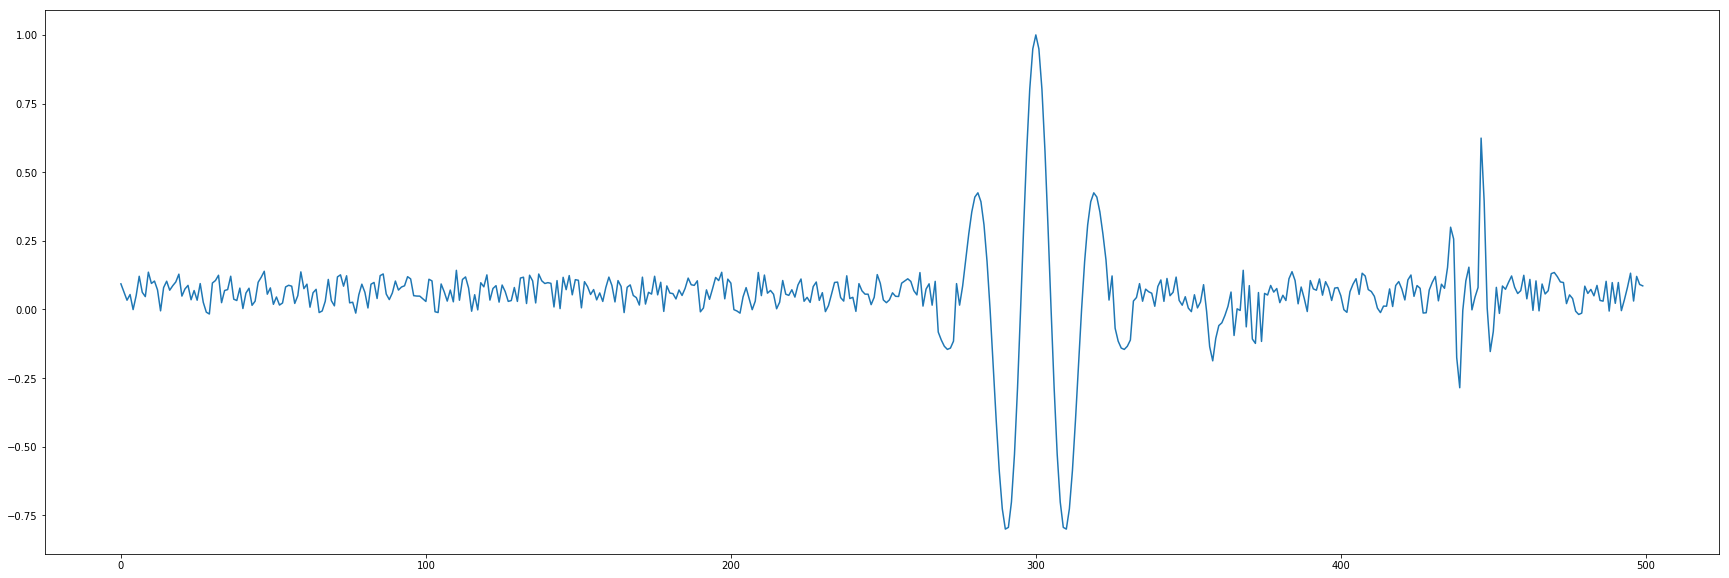

In [113]:
single_collar_length = 400
depth = 800*10
num_of_collars = int(depth / single_collar_length)

t = np.linspace(-5,5,single_collar_length, endpoint=False)
pseudo_ccl = np.array([], dtype=np.float32)

for collar in range(num_of_collars):
    i = signal.gausspulse(t, fc=2)
    pseudo_ccl = np.hstack((i, pseudo_ccl))

#not_ccl_idx = np.where(np.logical_and(pseudo_ccl>-0.1, pseudo_ccl<0.1))[0]
# for idx in not_ccl_idx:
#     pseudo_ccl[idx] = np.random.randn()/20.0


not_ccl_idx = []
idxs = []
for i in range(len(pseudo_ccl)):
    cur = i
    nxt = i+1
    try:
        if pseudo_ccl[cur] < 0.1 and pseudo_ccl[cur] > -0.1:
            if pseudo_ccl[nxt] < 0.1 and pseudo_ccl[nxt] > -0.1:
                idxs.append(i)
    except IndexError:
        break
    
m = 0
random_anomaly = False
random_anomaly_cntr = 0
for idx in idxs:
        
    if not random_anomaly:
        r = np.random.randint(0,1001)
        if r <= 1:
            #print("True", r)
            random_anomaly = True
            
    pseudo_ccl[idx] = modulated[m]
    
    if random_anomaly:
        if random_anomaly_cntr == 20:
            random_anomaly = False
            random_anomaly_cntr = 0
        pseudo_ccl[idx] *= (np.random.randn()*2)
        random_anomaly_cntr += 1
    m += 1
    
print(np.array(idxs).shape)
#print(not_ccl_idx)
# print(pseudo_ccl.shape)
plt.figure(figsize=(30,10))
plt.plot(pseudo_ccl[1500:2000])
# print(pseudo_ccl.size)

In [114]:
np.save('pseudo_ccl.npy', pseudo_ccl)

In [115]:
pseudo_ccl.shape, pseudo_ccl.nbytes/1000.0

((8000,), 64.0)

In [116]:
def write_progmem_line(data):
    string = "const float ccl_data[] PROGMEM = {"
    for i in range(len(data)):
        string += ((str(data[i])))
        if i != len(data)-1:
            string += ",\n"
    string += "};"
    return string

In [117]:
write_progmem_line(pseudo_ccl)

'const float ccl_data[] PROGMEM = {0.10705864819973271,\n0.05331906810660489,\n0.03916247781288819,\n0.07032909016871547,\n0.08161068449225253,\n0.03686543520461895,\n0.10279567486606803,\n0.06687458357729198,\n0.04704361526827288,\n0.04479877378565322,\n0.0485704957281232,\n0.10530460890883041,\n0.07402493631796037,\n0.026991489590756514,\n0.06483357700317002,\n0.09918213207320498,\n0.019901465630515227,\n0.009891231464740094,\n0.04822131649253626,\n0.04653500526318069,\n0.06251868923738609,\n0.09666823569980385,\n0.09064542956734042,\n0.08604403400975798,\n0.10718250199592753,\n0.06032582981521889,\n0.06337251758179319,\n0.04043131712606729,\n0.039449000162760345,\n0.07177353014603687,\n-0.003680640764042028,\n0.034643577328563345,\n0.03470465580973778,\n0.04766269605623401,\n0.04772551952594656,\n0.043421452135787346,\n0.06650024753523263,\n0.13046414326460698,\n0.13779409463921832,\n0.07864588388182095,\n0.08615576021028173,\n0.012861028039341164,\n0.028706100023054744,\n0.03421744

In [118]:
with open("ccl_data_flash.txt", "w") as f:
    f.write(write_progmem_line(pseudo_ccl))

(100, 1)


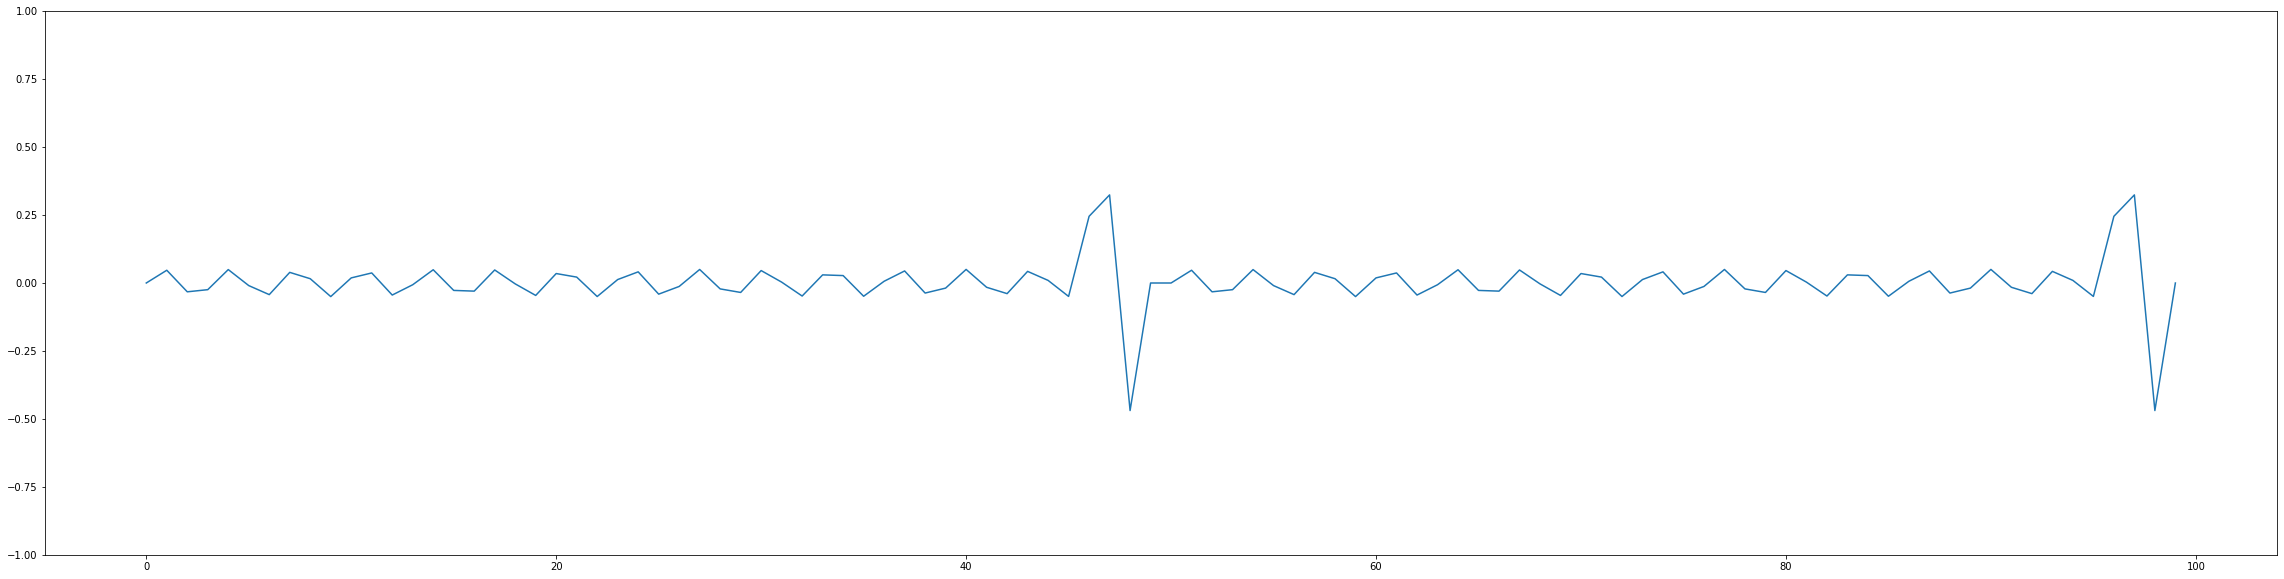

In [27]:
size = 50
x = np.linspace(0,size,size)
rads = 2.0*np.pi*x/100.0;
sin_y=  0.05*np.sin(30*rads) #* (np.random.randn(*sin_y.shape))

anomaly_mult = int(size *0.08)
sin_y[-anomaly_mult:-1] = sin_y[-anomaly_mult:-1]*10
ccl = np.tile([sin_y,],2).T



plt.figure(figsize=(40,10))
plt.ylim(-1,1)
plt.plot(ccl)
print(ccl.shape)


In [28]:
50 * 0.08

4.0

In [132]:
depth_rate = 300 - 299.5
depth_rate_ftmin = depth_rate * 60 * (1000.0 / 100.0)
depth_rate_ftmin

300.0

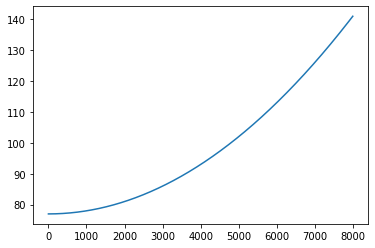

In [43]:
x= np.linspace(0,8000,8000)
plt.plot((x/1000)**2 + 77)

In [33]:
x = np.zeros((10,1))

In [36]:
x[:5] = np.random.randn()

In [53]:
last_element = np.nonzero(x)[0][-1]
last_element

4

In [57]:
np.nonzero(x)[0][-1]

4

In [64]:
x[1:4].shape

(3, 1)